In [1]:
import numpy as np
from src.tests.wrapper_stack import StackWrapper
from src.var_processor.pb_threshold import signal_pre_processor

74.55859375


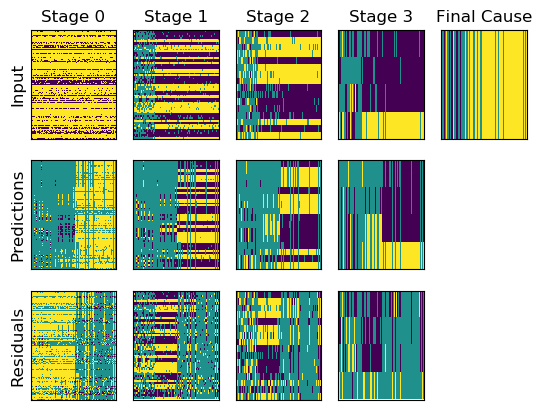

In [2]:
buf_length = 500
sen_length = 256
vec_len = 4
wrapper = StackWrapper(vec_len, sen_length, buf_length=buf_length)

# Generate fake data
data_in = np.random.randint(254, size=(sen_length, 1), dtype=np.uint8)
mean = np.asarray([127]*sen_length, dtype=np.uint8).reshape(-1, 1)

for i in range(0, buf_length):
    # Convert to ternary
    input_signal = signal_pre_processor(data_in, mean)
    wrapper.iterate(input_signal)
error, mse = wrapper.error(data_in, mean)
print(mse)
wrapper.plot_buffers()

In [3]:
buf_length = 500
sen_length = 256
vec_len = 4

# Create a set of wrappers for multiple stacks
wrappers = [
    StackWrapper(vec_len, sen_length, buf_length=buf_length)
    for i in range(0, vec_len)
]

mean = np.asarray([127]*sen_length, dtype=np.uint8).reshape(-1, 1)

for i in range(0, buf_length):
    # Generate fake data
    data_in = np.random.randint(254, size=(sen_length, 1), dtype=np.uint8)
    # Iterate over stacks
    input_signal = signal_pre_processor(data_in, mean)
    for wrapper in wrappers:
        _, _, residual = wrapper.iterate(input_signal)
        input_signal = residual

/home/ben/projects/var_processor/src/var_processor/power_iterator.py:20: RuntimeWarning: invalid value encountered in floor_divide
  scaled_array = (np.abs(array)*127//sq_root_sum)*signs


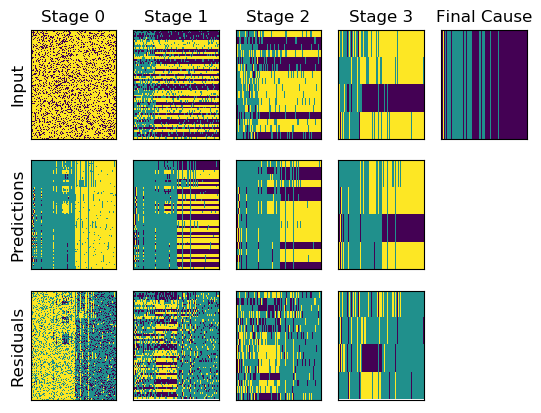

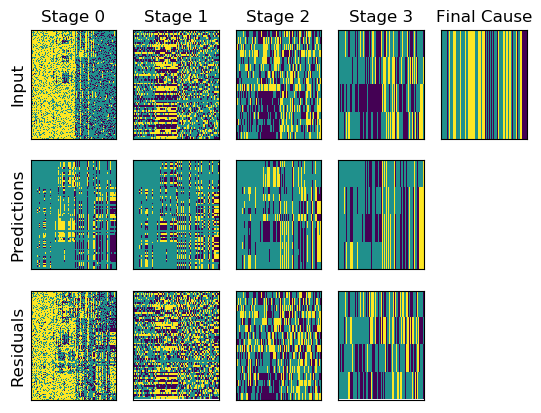

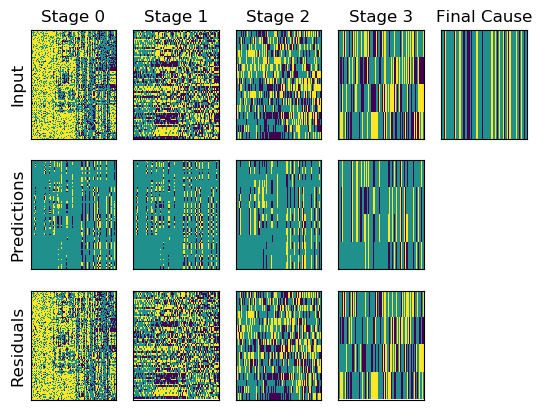

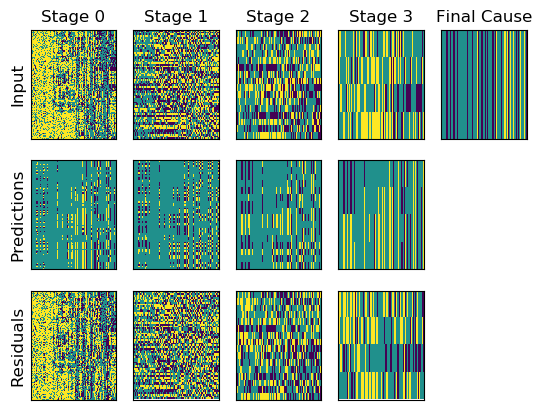

In [4]:
%matplotlib inline
for wrapper in wrappers:
    wrapper.plot_buffers()

One thing to remember in the above is that we are looking at the binary signals - if we reconstruct an original real input we may get close.

We are getting a zero eigenvector somewhere - it looks like in the fourth stage. But shouldn't our logic prevent this?

We need a way to visualise the eigenvectors...
* Each stage will have a set of eigenvectors from the VPU - we could have as a long array separated by zeros to space. Then we could plot as a bar chart.

In [5]:
for stage in wrappers[0].stack.get_eigenvectors():
    print(len(stage))

64
16
4
1


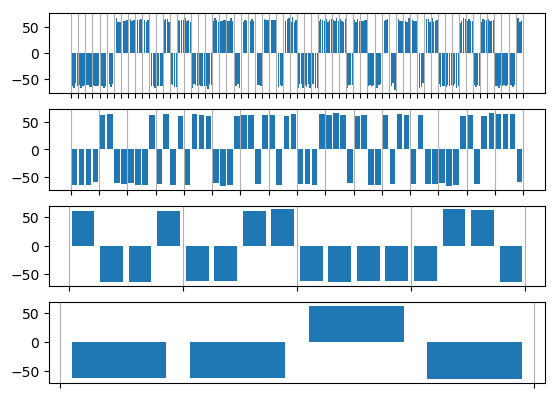

In [6]:
wrappers[0].plot_eigenvectors()

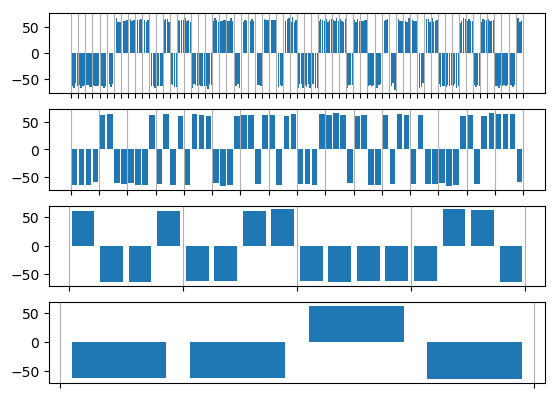

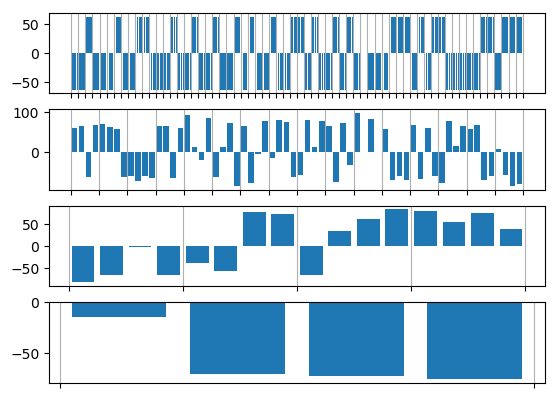

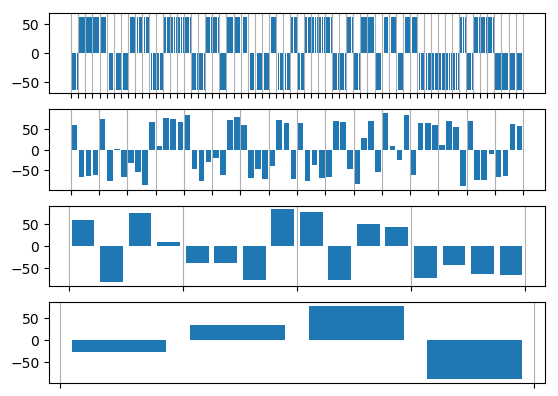

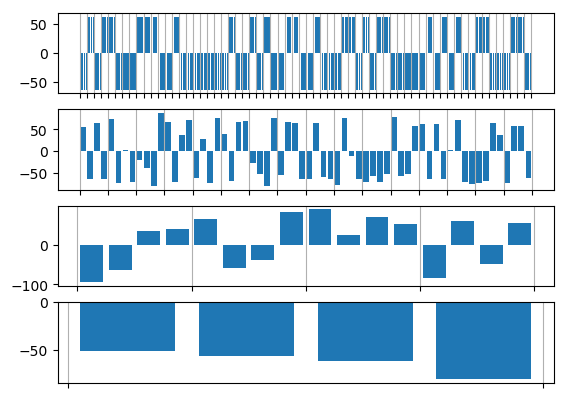

In [7]:
for wrapper in wrappers:
    wrapper.plot_eigenvectors()

# Visualising Input Reconstruction

Here's a plan:
* We need to visualise the input - as a 1D bar similar to our previous visualisations (VPU visualiser). We need this displayed in real time.
* We also need to visualise the predictions over time - it would be good to plot on the same graph as the input to compare so maybe we do make this a line graph. 
* We want to plot the different sums of predictions across different stacks - we should be more accurate as the stacks increase.
* We might also want some comparison over time - the input, reconstructions and errors as 2D plots.

See 

https://jakevdp.github.io/PythonDataScienceHandbook/04.01-simple-line-plots.html
https://python-graph-gallery.com/122-multiple-lines-chart/

We also need to sort the mean - this maybe done on the sensor side.

In [8]:
import matplotlib.pyplot as plt
from src.var_processor.sensor import Sensor
from src.sources.fft import FFTSource

Start by creating an audio FFT sensor source.

See here for additional materials - http://localhost:8888/notebooks/2020-03-22%20-%20Visualising%20Causes.ipynb.

In [9]:
audio = FFTSource(res_factor=2)
sensor = Sensor(audio, 4)

In [10]:
sensor.get_data_length()

256

In [11]:
_, initial_frame = sensor.source.read()

In [12]:
initial_frame.shape

(274,)

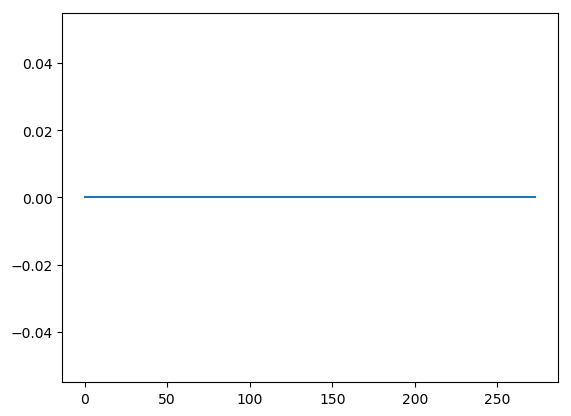

In [13]:
plt.plot(initial_frame)

In [14]:
for _ in range(0, 500):
    frame = sensor.get_frame()

In [15]:
self = sensor
_, initial_frame = self.source.read()
initial_frame.dtype

dtype('uint8')

In [16]:
from src.var_processor.sensor import resize

flattened = initial_frame.reshape(-1, 1)
# Resize to nearest power of vec_len
output = resize(flattened, self.power_len)
print(output.dtype, flattened.dtype)

float64 uint8


In [17]:
frame.T

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

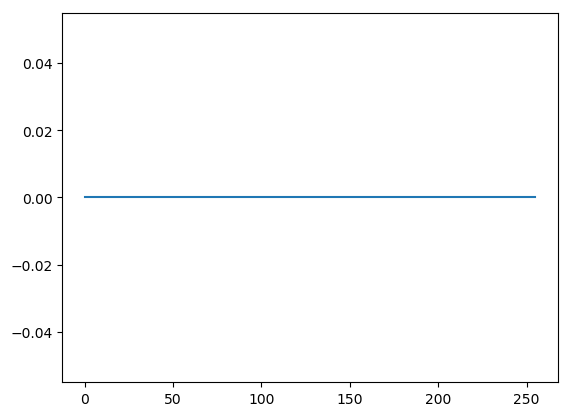

In [18]:
plt.plot(frame)

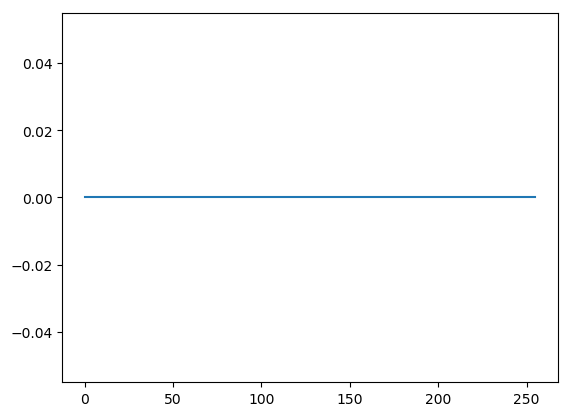

In [19]:
plt.plot(sensor.mean)

So when visualising, we can have:
* input data;
* mean;
* reconstructions.

Let'f first convert our stack wrapper into a sheet class that implements a plurality of stacks.

We could generate an abstract class that has the shared interfaces, then keep expanding this.

## Class Recap

We have the following data structures:
* Covariance
* Power Iterator
* VPU
* Stage
* Stack
* Sheet
* Sensor

In [20]:
from src.var_processor.sheet import Sheet

In [21]:
test = np.zeros(shape=(20, 4, 25))
addition = np.ones(shape=(20, 4))
test[:, :, 15] = addition
test[..., 15]

array([[1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.],
       [1., 1., 1., 1.]])

In [22]:
test[:, 3, :].mean(axis=1).shape

(20,)

In [23]:
test[:, 3, :].mean(axis=1)

array([0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04,
       0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04, 0.04])

We can use this example here to cycle through plot styles - https://matplotlib.org/examples/color/color_cycle_demo.html. Or here - the later reply with two examples is good.
https://stackoverflow.com/questions/4971269/how-to-pick-a-new-color-for-each-plotted-line-within-a-figure-in-matplotlib
```
color=iter(cm.rainbow(np.linspace(0,1,n)))
for i in range(n):
   c=next(color)
   plt.plot(x, y,c=c)
```

In [24]:
sums = test.sum(axis=2); print(sums)
sums_list = list(sums.T); print(len(sums_list))

[[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [1. 1. 1. 1.]]
4


In [25]:
sums.shape, list(range(0, sums.shape[1]))

((20, 4), [0, 1, 2, 3])

In [26]:
sums[:, 0:3].sum(axis=1).shape, sums[:, 0:3].sum(axis=1)

((20,),
 array([3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
        3., 3., 3.]))

In [27]:
totals = list()
for i in range(0, sums.shape[1]):
    totals.append(sums[:, 0:i+1].sum(axis=1))

In [28]:
totals = [sums[:, 0:i+1].sum(axis=1) for i in range(0, sums.shape[1])]

In [29]:
import time
from matplotlib.pyplot import cm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from src.var_processor.sheet import Sheet

In [30]:
cm.rainbow(np.linspace(0, 1, 4+2)).shape

(6, 4)

In [31]:
for color in cm.rainbow(np.linspace(0, 1, 4+2)):
    print(color)

[0.5 0.  1.  1. ]
[0.1        0.58778525 0.95105652 1.        ]
[0.3        0.95105652 0.80901699 1.        ]
[0.7        0.95105652 0.58778525 1.        ]
[1.         0.58778525 0.30901699 1.        ]
[1.0000000e+00 1.2246468e-16 6.1232340e-17 1.0000000e+00]


In [32]:
class SheetVisualizer:
    """Object to visualise a set of stacks."""

    def __init__(self, sheet, sensor, buf_length=127):
        """Initialise.

        Args:
            sheet: a sheet object.
            sensor: a sensor object.
        """
        assert isinstance(sheet, Sheet)
        assert isinstance(sensor, Sensor)
        self.sheet = sheet
        self.sensor = sensor
        self.buf_length = buf_length
        # Start sensor if not started
        if not self.sensor.source.started:
            self.sensor.start()
        # Initialise single subplot
        self.figure, self.ax = plt.subplots()
        # Initialising animation
        self.animation = FuncAnimation(
            self.figure, self.update, save_count=200)
        # Initialise X Axis
        self.x_range = np.arange(0, sen_length)
        # Set buffer for inputs
        self.input_buffers = np.zeros(
            shape=(sheet.input_len, sheet.stack_len, self.buf_length),
            dtype=np.int8
        )
        # Set count
        self.count = 0
        # Initialise Labels, Colors and Linestyles
        self.labels = ["Raw Input", "Sensor Mean"]
        self.labels = self.labels + [f"Input for Stack {i}" for i in range(0, self.sheet.stack_len)]
        self.colors = cm.rainbow(np.linspace(0, 1, self.sheet.stack_len+2))
        self.linestyles = ["-", "--", ":", ":", ":", ":"]
        # Initialise Data Plots
        # Set variable to store lines to update
        self.lines = [None for i in range(0, self.sheet.stack_len+2)]                         
        # Start with blank data                         
        zero_y = np.zeros(shape=(sheet.stack_len+2, sheet.input_len))
        self.set_plots(zero_y)  
        # Add legend
        self.ax.legend()
        self.ax.set_ylim(-127, 256)

    def set_plots(self, y_data):
        """Plot one or more lines on an axis.
    
        Args:
            y_data - list of 1D numpy arrays for y.
        """
        for i, y in enumerate(y_data):
            if self.lines[i] is None:
                self.lines[i], = self.ax.plot(
                    self.x_range,
                    y,
                    color=self.colors[i],
                    label=self.labels[i],
                    linestyle=self.linestyles[i]
                )
            else:
                self.lines[i].set_ydata(y)                             
                                 
    def update(self, frame):
        """Update the visualisations."""
        # Get mean-removed input data
        input_data, raw_frame = self.sensor.get_frame_plus_raw()
        causes, stack_inputs = self.sheet.iterate(input_data)
        self.input_buffers[:, :, self.count] = stack_inputs
        # Sum across samples in buffer
        sums = self.input_buffers.sum(axis=2).astype(np.int16)
        # Get mean and mean multiplier for reconstruction
        mean = self.sensor.mean
        mean_min = np.minimum(mean, 255-mean)
        # Total across more and more stacks for each reconstruction
        totals = [
            mean + (sums[:, 0:i+1].sum(axis=1).reshape(-1, 1)*mean_min)//127 
            for i in range(0, sums.shape[1])
        ]
        # Get y_data as list
        y_data = [raw_frame, mean] + totals
        # Update plots
        self.set_plots(y_data)
        # Increment Count and wrap if necessary
        self.count = (self.count + 1) % self.buf_length
        # time.sleep(0.25)
        return self.figure

    def show(self):
        """Show the visualisations."""
        plt.show()

We need to use set_data for the ydata.

We also need to multiply by the mean and add the mean back to our estimates

<IPython.core.display.Javascript object>


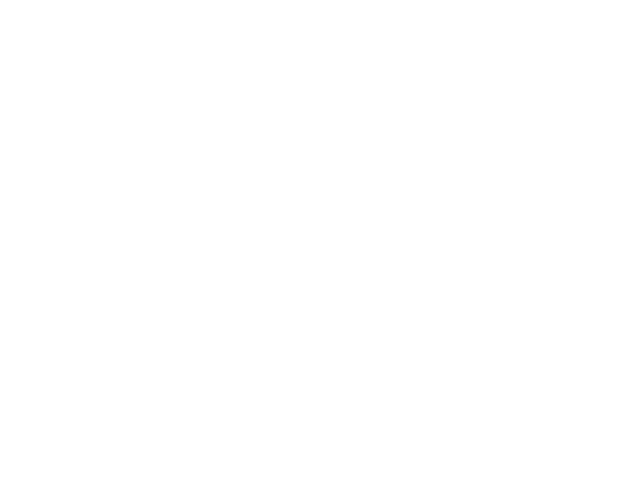

<IPython.core.display.Javascript object>


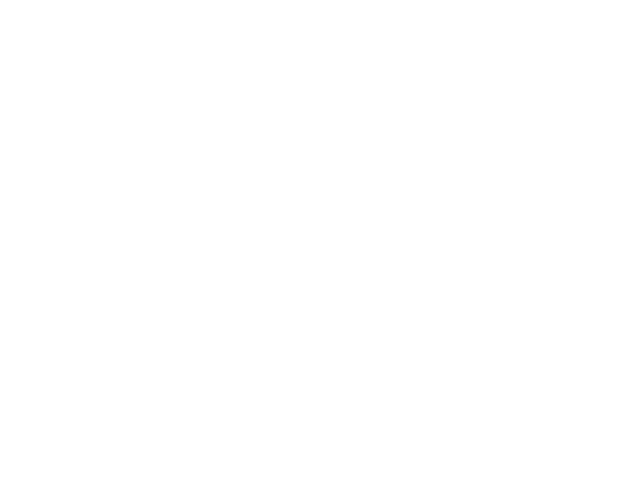

Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/var_processor/lib/python3.6/site-packages/matplotlib/cbook/__init__.py", line 215, in process
    func(*args, **kwargs)
  File "/home/ben/anaconda3/envs/var_processor/lib/python3.6/site-packages/matplotlib/animation.py", line 1478, in _stop
    self.event_source.remove_callback(self._loop_delay)
AttributeError: 'NoneType' object has no attribute 'remove_callback'


In [33]:
%matplotlib notebook
sheet = Sheet(4, 256)
sheet_vis = SheetVisualizer(sheet, sensor)
sheet_vis.show()

In [57]:
self = sheet_vis
# Get mean-removed input data
input_data, raw_frame = self.sensor.get_frame_plus_raw()
causes, stack_inputs = self.sheet.iterate(input_data)
self.input_buffers[:, :, self.count] = stack_inputs
# Sum across samples in buffer
sums = self.input_buffers.sum(axis=2).astype(np.int32)
# Get mean and mean multiplier for reconstruction
mean = self.sensor.mean
mean_min = np.minimum(mean, 255-mean)
# Total across more and more stacks for each reconstruction
totals = [
        mean + (sums[:, 0:i+1].sum(axis=1).reshape(-1, 1)*mean_min)//127
        for i in range(0, sums.shape[1])
]
# Get y_data as list
y_data = [raw_frame, mean] + totals
# Update plots
self.set_plots(y_data)
# Increment Count and wrap if necessary
self.count = (self.count + 1) % self.buf_length

In [58]:
input_data.T, raw_frame.T

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8),
 array([[  0,   0,   0,   0,   0,   1,   2,   0,   0,  10,   4,   0,   7,
           0,   0,  34,  13,  85,  

So the input and the raw frame are being computed correctly but the mean isn't - it's set to 0

In [37]:
self.sensor.sum.T

array([[    0,     0,     0,     0,     0,  1963,  3364,     0,     0,
         3755,  1613,     0,  7966,   499,     0, 13298,  3154, 20863,
            0,  5891, 10339, 11401, 10539, 11562,  5561, 26454,  5496,
        16212, 56294,  1651, 35994, 10313, 49719, 21508, 21388, 51057,
        21781, 22697, 34272, 34218, 25607,  2265, 46598, 44266, 50221,
        36295, 50373, 44561, 35575, 38712, 59542, 49987, 48301, 28728,
        46698, 43626, 21831, 21208, 46028, 74991, 73870, 37276, 51698,
        47522, 43796, 38914, 34439, 35516, 35359, 33015, 42389, 41056,
        60035, 74734, 46174, 69342, 68958, 44524, 39976, 33665, 32502,
        40277, 72933, 76884, 42078, 26727, 24472, 23573, 32394, 34586,
        35046, 32732, 27469, 31239, 68566, 82422, 69253, 52303, 38629,
        25056, 27347, 28350, 29427, 32792, 51287, 55256, 38443, 49264,
        58212, 49558, 53555, 53581, 33628, 33612, 29272, 47492, 35500,
        34811, 30789, 31705, 52819, 43035, 25204, 49505, 45598, 60052,
      

In [59]:
self.sensor.signal_mean.T

array([[  0,   0,   0,   0,   0,   3,   6,   0,   0,   7,   3,   0,  15,
          0,   0,  26,   6,  41,   0,  11,  20,  22,  20,  23,  11,  52,
         10,  32, 112,   3,  71,  20,  99,  42,  42, 101,  43,  45,  68,
         68,  51,   4,  92,  88, 100,  72, 100,  88,  70,  77, 118,  99,
         96,  57,  93,  86,  43,  42,  91, 149, 147,  74, 102,  94,  87,
         77,  68,  70,  70,  65,  84,  81, 119, 148,  91, 138, 137,  88,
         79,  67,  64,  80, 145, 153,  83,  53,  48,  46,  64,  68,  69,
         65,  54,  62, 136, 164, 137, 104,  76,  49,  54,  56,  58,  65,
        102, 110,  76,  98, 115,  98, 106, 106,  66,  66,  58,  94,  70,
         69,  61,  63, 105,  85,  50,  98,  90, 119,  97, 125, 129,  88,
         93,  99,  93, 140, 116,  93,  69,  56, 102,  63,  84,  48, 105,
         40,  36,  52,  62,  34,  46,  52,  44, 133,  73,  40,  42,  34,
         27,  27,  24,  25,  27,  34,  30,  29,  36,  34,  40,  36,  41,
         33,  36,  30,  29,  27,  27,  21,  21,  22

In [39]:
self.sensor.count

502

In [40]:
(self.sensor.sum//self.sensor.count).T

array([[  0,   0,   0,   0,   0,   3,   6,   0,   0,   7,   3,   0,  15,
          0,   0,  26,   6,  41,   0,  11,  20,  22,  20,  23,  11,  52,
         10,  32, 112,   3,  71,  20,  99,  42,  42, 101,  43,  45,  68,
         68,  51,   4,  92,  88, 100,  72, 100,  88,  70,  77, 118,  99,
         96,  57,  93,  86,  43,  42,  91, 149, 147,  74, 102,  94,  87,
         77,  68,  70,  70,  65,  84,  81, 119, 148,  91, 138, 137,  88,
         79,  67,  64,  80, 145, 153,  83,  53,  48,  46,  64,  68,  69,
         65,  54,  62, 136, 164, 137, 104,  76,  49,  54,  56,  58,  65,
        102, 110,  76,  98, 115,  98, 106, 106,  66,  66,  58,  94,  70,
         69,  61,  63, 105,  85,  50,  98,  90, 119,  97, 125, 129,  88,
         93,  99,  93, 140, 116,  93,  69,  56, 102,  63,  84,  48, 105,
         40,  36,  52,  62,  34,  46,  52,  44, 133,  73,  40,  42,  34,
         27,  27,  24,  25,  27,  34,  30,  29,  36,  34,  40,  36,  41,
         33,  36,  30,  29,  27,  27,  21,  21,  22

In [41]:
(self.sensor.sum//self.sensor.count).astype(np.uint8).T

array([[  0,   0,   0,   0,   0,   3,   6,   0,   0,   7,   3,   0,  15,
          0,   0,  26,   6,  41,   0,  11,  20,  22,  20,  23,  11,  52,
         10,  32, 112,   3,  71,  20,  99,  42,  42, 101,  43,  45,  68,
         68,  51,   4,  92,  88, 100,  72, 100,  88,  70,  77, 118,  99,
         96,  57,  93,  86,  43,  42,  91, 149, 147,  74, 102,  94,  87,
         77,  68,  70,  70,  65,  84,  81, 119, 148,  91, 138, 137,  88,
         79,  67,  64,  80, 145, 153,  83,  53,  48,  46,  64,  68,  69,
         65,  54,  62, 136, 164, 137, 104,  76,  49,  54,  56,  58,  65,
        102, 110,  76,  98, 115,  98, 106, 106,  66,  66,  58,  94,  70,
         69,  61,  63, 105,  85,  50,  98,  90, 119,  97, 125, 129,  88,
         93,  99,  93, 140, 116,  93,  69,  56, 102,  63,  84,  48, 105,
         40,  36,  52,  62,  34,  46,  52,  44, 133,  73,  40,  42,  34,
         27,  27,  24,  25,  27,  34,  30,  29,  36,  34,  40,  36,  41,
         33,  36,  30,  29,  27,  27,  21,  21,  22

In [43]:
self.sensor.signal_mean.T

array([[  0,   0,   0,   0,   0,   3,   6,   0,   0,   7,   3,   0,  15,
          0,   0,  26,   6,  41,   0,  11,  20,  22,  20,  23,  11,  52,
         10,  32, 112,   3,  71,  20,  99,  42,  42, 101,  43,  45,  68,
         68,  51,   4,  92,  88, 100,  72, 100,  88,  70,  77, 118,  99,
         96,  57,  93,  86,  43,  42,  91, 149, 147,  74, 102,  94,  87,
         77,  68,  70,  70,  65,  84,  81, 119, 148,  91, 138, 137,  88,
         79,  67,  64,  80, 145, 153,  83,  53,  48,  46,  64,  68,  69,
         65,  54,  62, 136, 164, 137, 104,  76,  49,  54,  56,  58,  65,
        102, 110,  76,  98, 115,  98, 106, 106,  66,  66,  58,  94,  70,
         69,  61,  63, 105,  85,  50,  98,  90, 119,  97, 125, 129,  88,
         93,  99,  93, 140, 116,  93,  69,  56, 102,  63,  84,  48, 105,
         40,  36,  52,  62,  34,  46,  52,  44, 133,  73,  40,  42,  34,
         27,  27,  24,  25,  27,  34,  30,  29,  36,  34,  40,  36,  41,
         33,  36,  30,  29,  27,  27,  21,  21,  22

In [44]:
mean_min.shape

(256, 1)

In [63]:
_, initial_frame = self.sensor.source.read()
flattened = initial_frame.reshape(-1, 1)
# Resize to nearest power of vec_len
output = resize(flattened, self.sensor.power_len).astype(np.uint8)
mean_2 = self.sensor.update_mean(output)

In [64]:
output.T

array([[  0,   0,   0,   0,   0,  17,  29,   0,   0,  23,  10,   0,  43,
          4,   0,  37,   8,  52,   0,  16,  28,  20,  18,  26,  13,  95,
         20, 105, 132,   0,   5,   7,  46,  47,  53,  78,   7,  37,  71,
         66,  47,   4, 198,  73, 166, 136, 117,  83, 130, 112, 118, 131,
        168,  90,  59, 142, 152, 217, 162,  71, 192, 115, 216, 193, 187,
        224,  90, 157, 161, 205, 119, 164, 131,  92,  96,  70,  97, 149,
        115,  55,  53,  77,  81,  71,  83,  48,  57,  78, 111,  82,  98,
         70,  63,  58,  59,  78,  67,  57,  64,  41,  75,  86, 195, 102,
         64,  46,  39,  48,  48,  59,  65, 102,  91,  42,  35,  42,  72,
         39,  28,  30,  42,  41,  32,  28,  27,  22,  37,  25,  41, 118,
         26,  30,  60, 114,  78,  38,  27,  28,  66,  33,  30,  40,  21,
         19,  25,  22,  26,  21,  24,  22,  25,  24,  24,  18,  16,  20,
         13,  14,  16,  15,  15,  15,  15,  16,  15,  16,  17,  17,  18,
         15,  19,  16,  16,  15,  13,  12,  10,   9

In [65]:
mean_2.T

array([[  0,   0,   0,   0,   0,   3,   6,   0,   0,   7,   3,   0,  15,
          0,   0,  26,   6,  41,   0,  11,  20,  22,  20,  23,  11,  52,
         10,  32, 112,   3,  71,  20,  99,  42,  42, 101,  43,  45,  68,
         68,  51,   4,  92,  88, 100,  72, 100,  88,  70,  77, 118,  99,
         96,  57,  93,  86,  43,  42,  91, 149, 147,  74, 102,  94,  87,
         77,  68,  70,  70,  65,  84,  81, 119, 148,  91, 138, 137,  88,
         79,  67,  64,  80, 145, 153,  83,  53,  48,  46,  64,  68,  69,
         65,  54,  62, 136, 164, 137, 104,  76,  49,  54,  56,  58,  65,
        102, 110,  76,  98, 115,  98, 106, 106,  66,  66,  58,  94,  70,
         69,  61,  63, 105,  85,  50,  98,  90, 119,  97, 125, 129,  88,
         93,  99,  93, 140, 116,  93,  69,  56, 102,  63,  84,  48, 105,
         40,  36,  52,  62,  34,  46,  52,  44, 133,  73,  40,  42,  34,
         27,  27,  24,  25,  27,  34,  30,  29,  36,  34,  40,  36,  41,
         33,  36,  30,  29,  27,  27,  21,  21,  22

In [66]:
from src.var_processor.sensor import signal_adjust

signed = signal_adjust(output, mean_2)

In [67]:
(output - mean_2).astype(np.int16).T

array([[  0,   0,   0,   0,   0,  14,  23,   0,   0,  16,   7,   0,  28,
          4,   0,  11,   2,  11,   0,   5,   8, 254, 254,   3,   2,  43,
         10,  73,  20, 253, 190, 243, 203,   5,  11, 233, 220, 248,   3,
        254, 252,   0, 106, 241,  66,  64,  17, 251,  60,  35,   0,  32,
         72,  33, 222,  56, 109, 175,  71, 178,  45,  41, 114,  99, 100,
        147,  22,  87,  91, 140,  35,  83,  12, 200,   5, 188, 216,  61,
         36, 244, 245, 253, 192, 174,   0, 251,   9,  32,  47,  14,  29,
          5,   9, 252, 179, 170, 186, 209, 244, 248,  21,  30, 137,  37,
        218, 192, 219, 206, 189, 217, 215, 252,  25, 232, 233, 204,   2,
        226, 223, 223, 193, 212, 238, 186, 193, 159, 196, 156, 168,  30,
        189, 187, 223, 230, 218, 201, 214, 228, 220, 226, 202, 248, 172,
        235, 245, 226, 220, 243, 234, 226, 237, 147, 207, 234, 230, 242,
        242, 243, 248, 246, 244, 237, 241, 243, 235, 238, 233, 237, 233,
        238, 239, 242, 243, 244, 242, 247, 245, 243

In [68]:
mean_2.T

array([[  0,   0,   0,   0,   0,   3,   6,   0,   0,   7,   3,   0,  15,
          0,   0,  26,   6,  41,   0,  11,  20,  22,  20,  23,  11,  52,
         10,  32, 112,   3,  71,  20,  99,  42,  42, 101,  43,  45,  68,
         68,  51,   4,  92,  88, 100,  72, 100,  88,  70,  77, 118,  99,
         96,  57,  93,  86,  43,  42,  91, 149, 147,  74, 102,  94,  87,
         77,  68,  70,  70,  65,  84,  81, 119, 148,  91, 138, 137,  88,
         79,  67,  64,  80, 145, 153,  83,  53,  48,  46,  64,  68,  69,
         65,  54,  62, 136, 164, 137, 104,  76,  49,  54,  56,  58,  65,
        102, 110,  76,  98, 115,  98, 106, 106,  66,  66,  58,  94,  70,
         69,  61,  63, 105,  85,  50,  98,  90, 119,  97, 125, 129,  88,
         93,  99,  93, 140, 116,  93,  69,  56, 102,  63,  84,  48, 105,
         40,  36,  52,  62,  34,  46,  52,  44, 133,  73,  40,  42,  34,
         27,  27,  24,  25,  27,  34,  30,  29,  36,  34,  40,  36,  41,
         33,  36,  30,  29,  27,  27,  21,  21,  22

In [69]:
signed.T

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int8)

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/ben/anaconda3/envs/var_processor/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/ben/anaconda3/envs/var_processor/lib/python3.6/threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ben/projects/var_processor/src/sources/capture.py", line 127, in update
    self.length, data = self.inp.read()
alsaaudio.ALSAAudioError: Streams pipe error [default]



In [52]:
(sums[:, 0:i+1].sum(axis=1)).shape

(256,)

In [53]:
(sums[:, 0:i+1].sum(axis=1)*mean_min).shape

(256, 256)

<IPython.core.display.Javascript object>


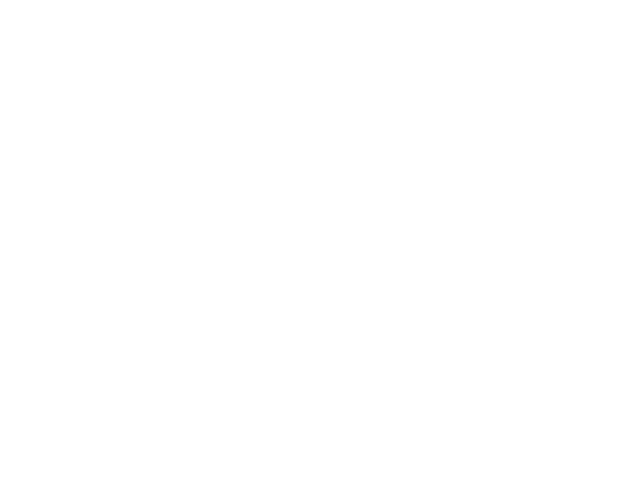

<IPython.core.display.Javascript object>


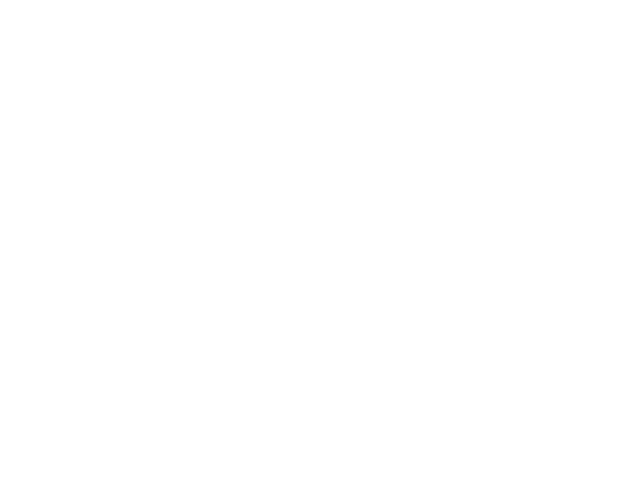

In [54]:
input_data, raw_frame = self.sensor.get_frame_plus_raw()
fig, ax = plt.subplots()
line, = ax.plot(raw_frame)